# Analysis of visual cortical neurons of mice

# What this graph is about

Data of this graph was collected from the study of the paper [[3]](README.md#references).

The aim of the graph is to understand better the connections and structor of neurons in the primary visual cortex of a mouse.

Researchers have simulated visual stimulus on some neurons and tracked where the synapsis were propagated or not.

## Data components

Three types of components were tracked:

- Characterized pyramidal neuron
- Cell body in EM volume
- Dendritic fragment

We will try to get a brief explanation of these components.

### Characterized pyramidal neuron

These are the neurons that were stimulated with two-photon calcium imaging. A specific visual 
stimulus is created with this technique.
> Every synapse starts from one of them.

### Cell body in EM volume

These are the neurons that are targeted from the synapse. With the large-scale electron microscopy (EM), like we described in the [README](README.md#scope-of-the-paper), is it possible 
to trace a portion of the local network of these neurons.

### Dendritic fragment

Part of the neuron specialized in retrieving signals from other neurons. It is different from the 
axon which is specialized in sending signals to other neurons.

> We have *fragment* because the Dendritic is highly branched, so only a fraction of it was tracked.   

## Further division of the components

We said that a **pyramidal neuron** "starts" the synapse targeting a specific neuron.

Post-Synaptic data was also collected, so the components: *Cell body in EM volume* and *Dendritic fragment* can be classified to:

- Postsynaptic excitatory target,
- Postsynaptic inhibitory target

**excitatory** and **inhibitory** means: "A target that *propagates* the signal and a target that *stops* the signal respectively."

> Since all the synapses start from the *characterized pyramidal neurons*, they do not have this further division and that attribute is marked as *NA*.
 

# Before Starting the analysis

Now that we know **what** data is collected, **why** and **how**, we can formulate questions.

This is an important step because we must know what we are looking for, otherwise we might not be able to see it if we find it.

We can split the techniques to answer the questions, and the rest of the notebook, in two categories:

1. [Descriptive analysis](#descriptive-analysis)
2. [Statistical modeling](#statistical-modeling)

> We will not use any machine learning technique, since is out of the scope of this course. 
> We will focus on the statistical aspects of Network data.


## Analysis questions

some questions to discuss later here. :)

# Descriptive analysis

We now start from the descriptive analysis since is easier and let's us take confidence with these dataset.

In [1]:
import igraph as ig
import matplotlib.pyplot as plt
import random

First step is to importing the graph downloaded from the site [[2]](/README.md#references).

Unfortunately with this version we are using of iGraph, we can't read from an URL.

The data was downloaded and put in the [Data](Data/mouse_visual.cortex_2.graphml) folder.

In [2]:
neurons : ig.Graph
neurons = ig.Graph.Read_GraphML("Data/mouse_visual.cortex_2.graphml")
neurons.to_directed()

> Since the return type of `Read_GraphML` is erroneously hinted as `None` (which is not because is a `Graph`) we hint the interpreter thar `neurons` is a `Graph`, so we can use autocompletion and suggestions.

As we saw before, we have three types of nodes in this network and are described as nodal attributes of name `type1`

In [3]:
print(f"The three node possible types are : {set(neurons.vs['type1'])}")

The three node possible types are : {'Cell body in EM volume', 'Dendritic fragment', 'Characterized pyramidal neuron'}


Furthermore if a node is a Postsynaptic target, i.e. if a node is not a `Characterized pyramidal neuron`, 
we have two others classifications:

In [4]:
print(f"We can further classify as: {set(neurons.vs['type2'])}")

We can further classify as: {'Postsynaptic inhibitory target', 'NA', 'Postsynaptic excitatory target'}


The fact that if a node is a `Characterized pyramidal neuron` then the attribute `type2` is `NA`, 
can be proved with the following lines of code.

In [5]:
def check_type1_can_only_be_type2(graph:ig.Graph,type1:str,type2:str) -> bool:
    for node in list(graph.vs):
        if node["type1"] == type1:
             if not (node["type2"] == type2):
                return False
    return True
print("{type1} can only be {type2}: {assertion}.".format(type1='Characterized pyramidal neuron',type2 = 'NA', assertion = check_type1_can_only_be_type2(neurons,'Characterized pyramidal neuron','NA')))

Characterized pyramidal neuron can only be NA: True.


## Plottig the network

Let's now plot the data.

We will use `matplotlib` for backend.

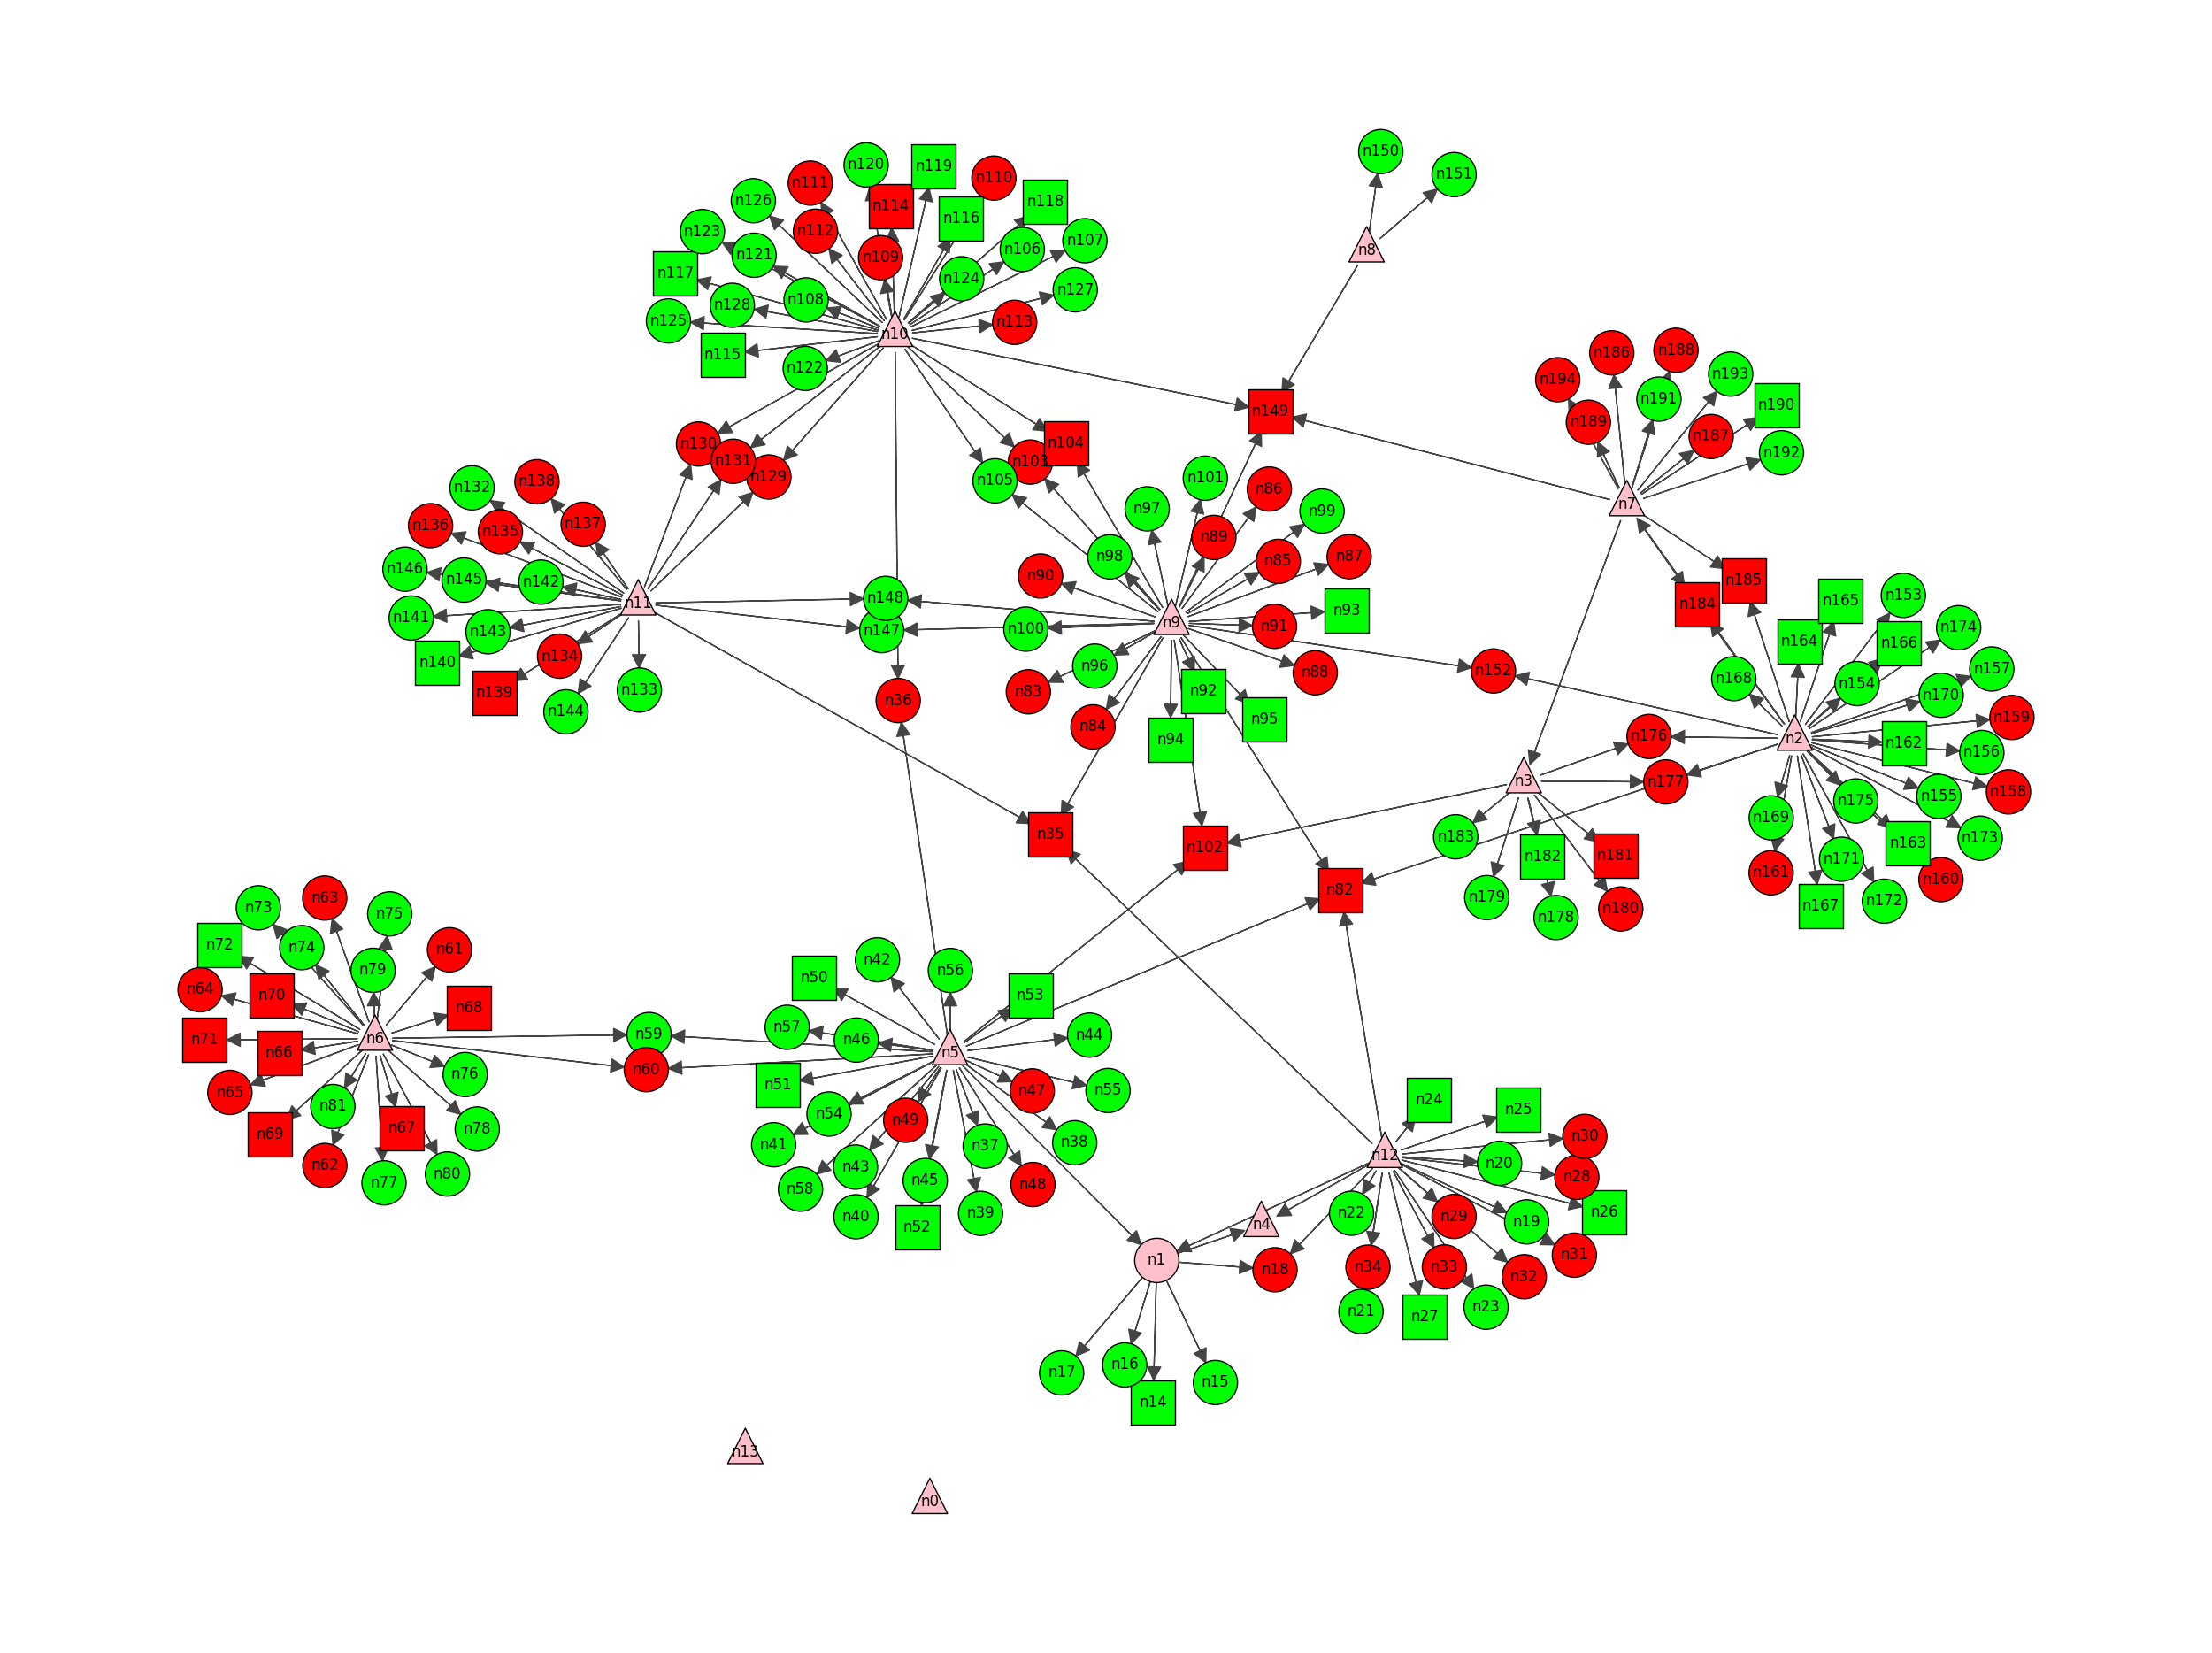

In [6]:
random.seed(42)

fig, ax = plt.subplots(figsize=(32,24))
ig.plot(
    neurons,
    target=ax,
    layout="fruchterman_reingold",
    vertex_shape = ["circle" if type == "Dendritic fragment" else "square" if type == "Cell body in EM volume" else "triangle" for type in neurons.vs["type1"]],
    vertex_size=[40 if type == "Characterized pyramidal neuron" else 50 for type in neurons.vs["type1"]],
    vertex_label=neurons.vs["id"],
    vertex_color=["green" if type == "Postsynaptic excitatory target" else "red" if type == "Postsynaptic inhibitory target" else "pink" for type in neurons.vs["type2"]],
    edge_width = 1
)
plt.savefig("Plots/neurons.png")
plt.show()

# Statistical Modeling

We will start from the easiest to more complex models.

The first model we will use is the Binomial Random Graph Model, which is just a base model that we can use as a basline and to compere with other complex models.

## Binomial Random Graph Model

We will use the naive approach.

> Generally, the formal and the naive procedure lead to identical conclusions.

For Simulating and assesing significance from the Binomial Random Graph Model we need:

1. A network statistic of our choice from the observed data,
2. The null distribution under $H_0$ which we need to aproximate via Monte Carlo,
3. A graphical or via p-value comparison.

In [7]:
import numpy as np
import seaborn as sns

# get the adjacency matrix, and the MLE of rho
adj_matrix = np.array(neurons.get_adjacency().data)
n = adj_matrix.shape[0]
p_MLE = np.mean(adj_matrix)

B = 1000
rho_sim = np.zeros(B)

for b in range(B):
    # sample from a Bernoulli
    adj_sim = np.random.binomial(1, p_MLE, n**2).reshape((n, n))
    np.fill_diagonal(adj_sim, 0)
    # compute rho from the simulated adjacency matrix
    rho_sim[b] = np.mean(adj_sim)

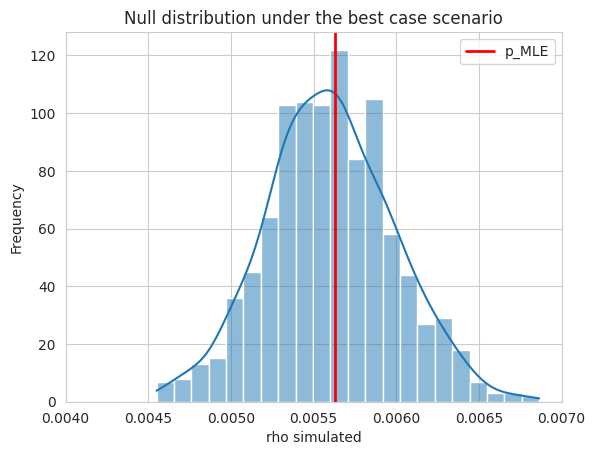

In [8]:
ax = sns.histplot(rho_sim, kde=True)
ax.axvline(x=p_MLE, linewidth=2, color='red', label='p_MLE')
ax.set_xlim(0.004, 0.007)

plt.legend()
plt.title("Null distribution under the best case scenario")
plt.xlabel("rho simulated")
plt.ylabel("Frequency")

plt.savefig("Plots/Binomial/null_dist.png")
plt.show()

In [9]:
B = 1000
transitivity_sim = np.zeros(B)
degree_sim = np.zeros(B)

for b in range(B):
    adj_sim = np.random.binomial(1, p_MLE, n**2).reshape((n, n))
    np.fill_diagonal(adj_sim, 0)
    
    simulated_graph = ig.Graph.Adjacency((adj_sim > 0).tolist())
    degree_sim[b] = np.mean(simulated_graph.degree())
    transitivity_sim[b] = simulated_graph.transitivity_undirected()

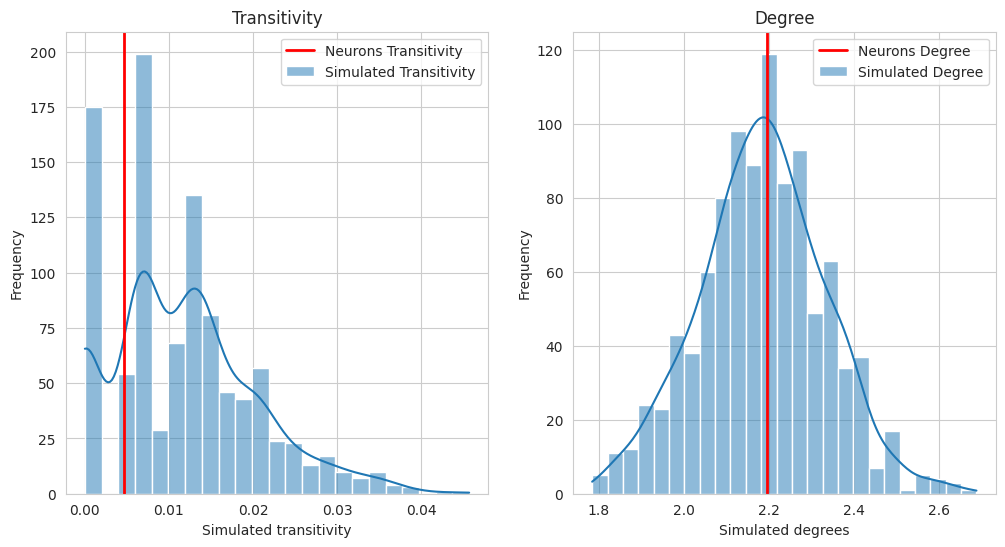

In [10]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(transitivity_sim, label='Simulated Transitivity',kde=True)
plt.axvline(x=neurons.transitivity_undirected(), linewidth=2, color='red', label='Neurons Transitivity')
plt.legend()
plt.title("Transitivity")
plt.xlabel("Simulated transitivity")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(degree_sim, label='Simulated Degree',kde=True)
plt.axvline(x=np.mean(neurons.degree()), linewidth=2, color='red', label='Neurons Degree')
plt.legend()
plt.title("Degree")
plt.xlabel("Simulated degrees")
plt.ylabel("Frequency")

plt.savefig("Plots/Binomial/transitivity_degree.png")
plt.show()

In [11]:
degree_p_value = np.mean(degree_sim <= np.mean(neurons.degree()))
transitivity_p_value = np.mean(transitivity_sim >= neurons.transitivity_undirected())

print("Degree p-value:", degree_p_value)
print("Transitivity p-value:", transitivity_p_value)

Degree p-value: 0.544
Transitivity p-value: 0.825
